In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import h5py
import shutil
from tqdm import tqdm

import numpy as np

from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp

import powerbox as pbox

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file('../matplotlibrc')

## 0. Get lightcones

In [2]:
ddir = '/n/holyscratch01/iaifi_lab/yitians/dm21cm/outputs/fc_xdecay'

In [3]:
! ls /n/holyscratch01/iaifi_lab/yitians/dm21cm/outputs/fc_xdecay

lc_fc_xdecay_zf001_sf20_noxesink.h5  lc_fc_xdecay_zf005_sf4_noxesink.h5
lc_fc_xdecay_zf001_sf20_xesink.h5    lc_fc_xdecay_zf005_sf4_xesink.h5
lc_fc_xdecay_zf002_sf10_noxesink.h5  lc_fc_xdecay_zf01_sf2_noxesink.h5
lc_fc_xdecay_zf002_sf10_xesink.h5    lc_fc_xdecay_zf01_sf2_xesink.h5


In [3]:
# zf_s = ['001', '002', '005', '01']
# sf_s = [20, 10, 4, 2]
zf_s = ['001', '002', '005']
sf_s = [20, 10, 4]
keys = ['T_k', 'x_e', 'T_b']

In [4]:
# load fields
box_s = {k : [] for k in keys}

for i in range(len(zf_s)):
    with h5py.File(f"{ddir}/lc_fc_xdecay_zf{zf_s[i]}_sf{sf_s[i]}_xesink.h5", 'r') as hf:
        box_s['T_k'].append(hf['lightcones']['Tk_box'][()])
        box_s['x_e'].append(hf['lightcones']['x_e_box'][()])
        box_s['T_b'].append(hf['lightcones']['brightness_temp'][()])
for k in keys:
    box_s[k] = np.array(box_s[k])

(array([4.3797e+04, 3.9770e+03, 9.3400e+02, 2.3400e+02, 9.4000e+01,
        6.4000e+01, 3.1000e+01, 9.0000e+00, 6.0000e+00, 6.0000e+00]),
 array([ 0.25775051,  8.750494  , 17.24323845, 25.73598099, 34.22872543,
        42.72146988, 51.21421432, 59.70695877, 68.1996994 , 76.69244385,
        85.18518829]),
 <BarContainer object of 10 artists>)

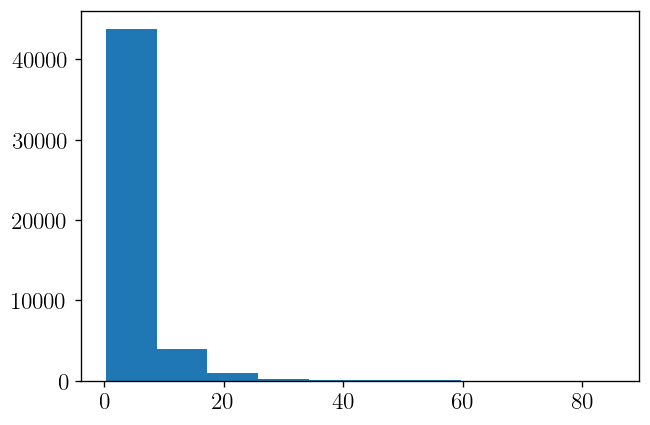

In [16]:
plt.hist(box_s['T_b'][:, :, :, 1].flatten())

In [6]:
cmap_dict = {
    'T_k' : cms['magma'],
    'x_e' : cms['viridis'],
    'T_b' : cms['twilight_shifted']
}
title_dict = {
    'T_k' : r'\textbf{Kinetic temperature} $T_k$ [K]',
    'x_e' : r'\textbf{Ionization fraction} $x_e$',
    'T_b' : r'\textbf{Brightness temperature} $T_{21}$ [mK]'
}
zf_labels = [
    r'$(z+\Delta z)/z=1.001$',
    r'$(z+\Delta z)/z=1.002$',
    r'$(z+\Delta z)/z=1.005$',
    r'$(z+\Delta z)/z=1.01$',
]
range_dict = {
    'T_k' : (14000, 20000),
    'x_e' : (0.12, 0.135),
    'T_b' : (0, 30)
}

/tmp/ipykernel_624007/932772398.py:29: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.05, hspace=0.03)


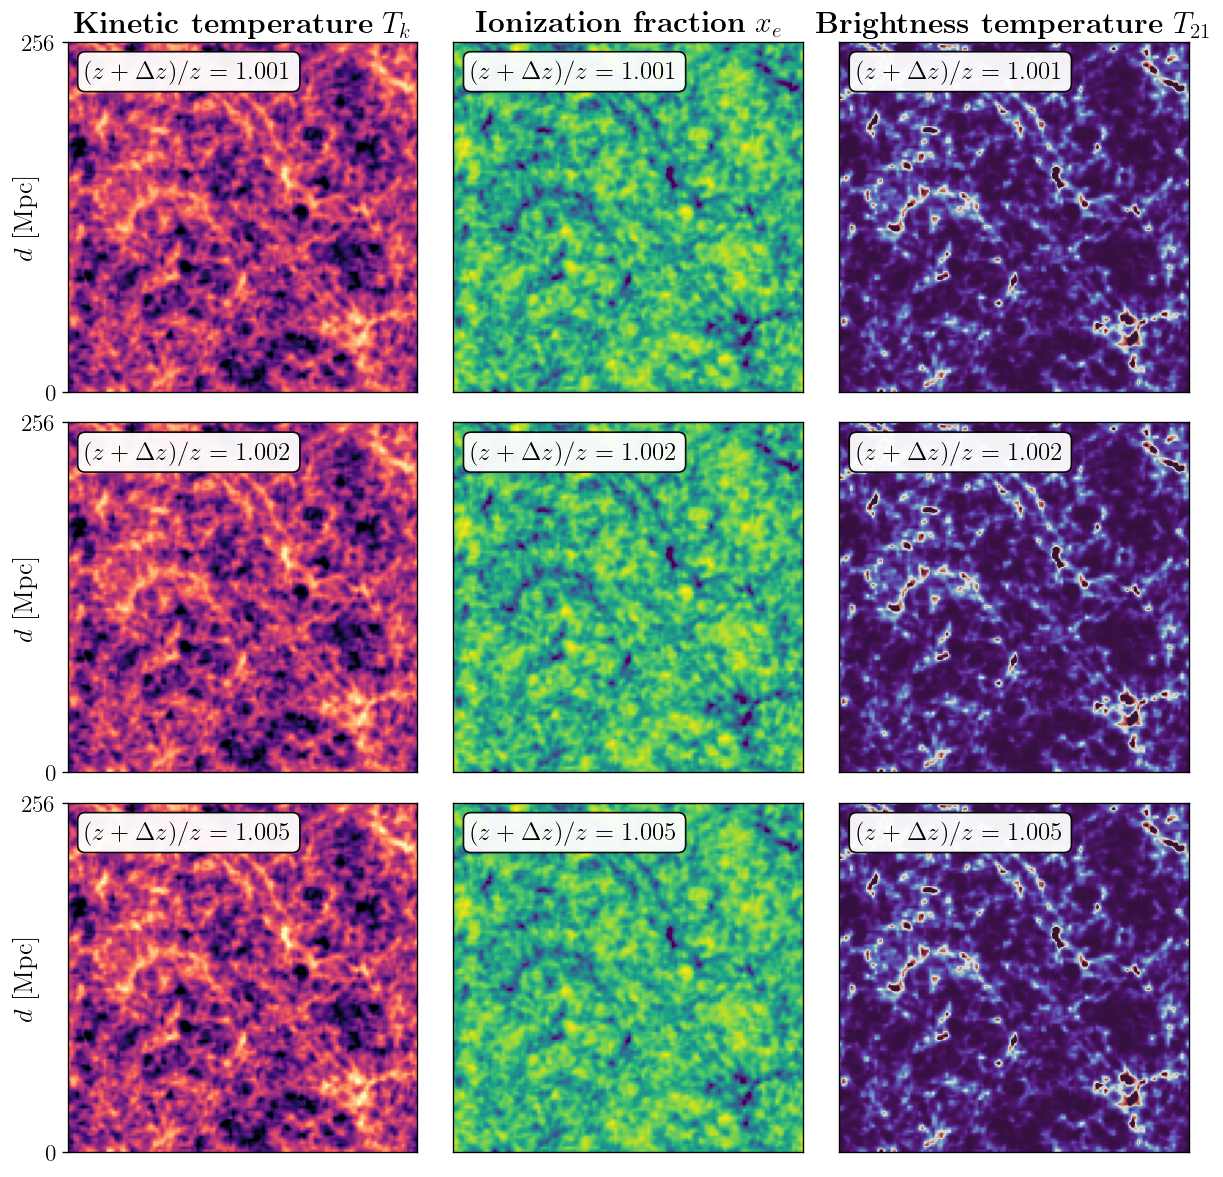

In [12]:
colorbar = False

if colorbar:
    fig, axs = plt.subplots(3, 3, figsize=(10, 10.5), layout='constrained')
else:
    title_dict = {
        'T_k' : r'\textbf{Kinetic temperature} $T_k$',
        'x_e' : r'\textbf{Ionization fraction} $x_e$',
        'T_b' : r'\textbf{Brightness temperature} $T_{21}$'
    }
    fig, axs = plt.subplots(3, 3, figsize=(10, 9.7), layout='constrained')

for i in range(3):
    for j, k in enumerate(keys):
        ax = axs[i, j]
        im = ax.imshow(box_s[k][i][:, :, 1], origin='lower', cmap=cmap_dict[k], vmin=range_dict[k][0], vmax=range_dict[k][1], extent=(0, 256, 0, 256))
        ax.set(xticks=[], yticks=[])
        ax.text(0.05, 0.95, zf_labels[i], transform=ax.transAxes, ha='left', va='top', fontsize=15, bbox=dict(boxstyle='round', facecolor='white', alpha=0.95))
        if i == 2:
            if colorbar:
                fig.colorbar(im, ax=axs[:, j], orientation='horizontal', pad=0.01, shrink=0.8, aspect=15)

for j, k in enumerate(keys):
    axs[0, j].set_title(title_dict[k], fontsize=18)
for i in range(3):
    axs[i, 0].set_ylabel(r'$d$ [Mpc]', labelpad=-10, fontsize=16)
    axs[i, 0].set_yticks([0, 256])

fig.subplots_adjust(wspace=0.05, hspace=0.03)
fig.savefig('convergence-field.pdf')

## Power spectrum

In [13]:
import py21cmfast as p21c

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


In [14]:
def compute_power(
   box,
   length,
   n_psbins,
   log_bins=True,
   ignore_kperp_zero=True,
   ignore_kpar_zero=False,
   ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = pbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

BOX_LEN = 256 # [Mpc]

def powerspectra(brightness_temp, z_start, z_end, n_psbins=30, logk=True):
    lightcone_redshifts = brightness_temp.lightcone_redshifts
    i_start = np.argmin(np.abs(lightcone_redshifts - z_start))
    i_end = np.argmin(np.abs(lightcone_redshifts - z_end))

    chunklen = (i_end - i_start) * brightness_temp.cell_size

    power, k = compute_power(
        brightness_temp.brightness_temp[:, :, i_start:i_end],
        (BOX_LEN, BOX_LEN, chunklen),
        n_psbins,
        log_bins=logk,
    )
    return {
        "k": k,
        "delta": power * k ** 3 / (2 * np.pi ** 2)
    }

In [15]:
lc_s = [p21c.LightCone.read(f"{ddir}/lc_fc_xdecay_zf{zf_s[i]}_sf{sf_s[i]}_xesink.h5") for i in range(3)]
ps_s_s = []
for z in tqdm([5, 7, 9, 11, 13, 15, 17, 19, 21, 23]):
    ps_s_s.append([powerspectra(lc, z, z+2) for lc in lc_s])

  0%|          | 0/10 [00:00<?, ?it/s]/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:325: UserWarning: One or more radial bins had no cells within it.
  return angular_average(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:180: RuntimeWarning: invalid value encountered in divide
  np.bincount(
100%|██████████| 10/10 [03:54<00:00, 23.41s/it]


### horizontal

In [19]:
zf_labels = [
    '1.001',
    '1.002',
    '1.005',
    '1.01',
]

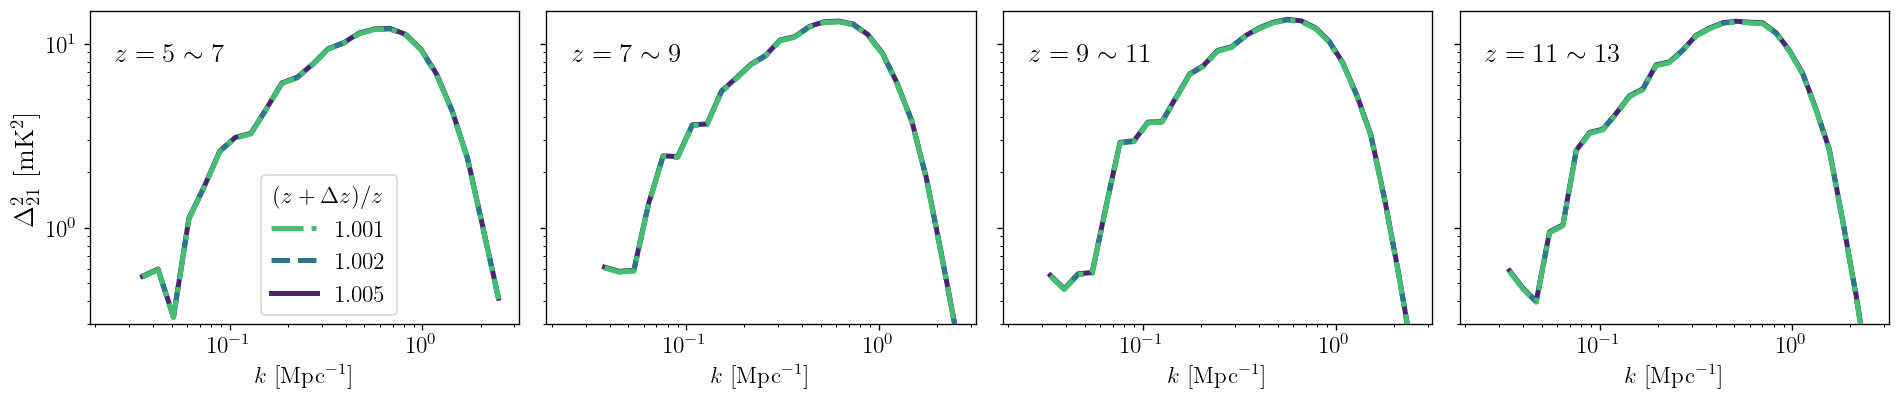

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(16, 3.5), sharex=True, sharey=True)

x_s = [0.3, 0.6, 0.9]
color_s = [cms['viridis_r'](x) for x in x_s]
ls_s = ['-.', '--', '-']

for i_plot in range(4):
    i_ps = i_plot + 1
    ax = axs.flatten()[i_plot]
    for i in range(3):
        ps = ps_s_s[i_ps][i]
        ax.plot(ps['k'], ps['delta'], color=color_s[i], label=zf_labels[i], zorder=10-i, lw=3, alpha=1., ls=ls_s[i])
    ax.text(0.06, 0.9, f'$z={5+i_plot*2}\\sim{7+i_plot*2}$', transform=ax.transAxes, ha='left', va='top', fontsize=16)
    ax.set(xscale='log', yscale='log', ylim=(0.3, 15))
    #ax.set(ylabel=r'$\Delta_{21}^2$ [mK$^2$]')

axs[0].legend(fontsize=14, loc=(0.4, 0.03), title=r'$(z+\Delta z)/z$', title_fontsize=14)
for i_plot in range(4):
    axs[i_plot].set(xlabel=r'$k$ [Mpc$^{-1}$]')
axs[0].set_ylabel(r'$\Delta^2_{21}$ [mK$^2$]', fontsize=16)

fig.tight_layout()
fig.savefig('convergence-ps.pdf')

### vertical

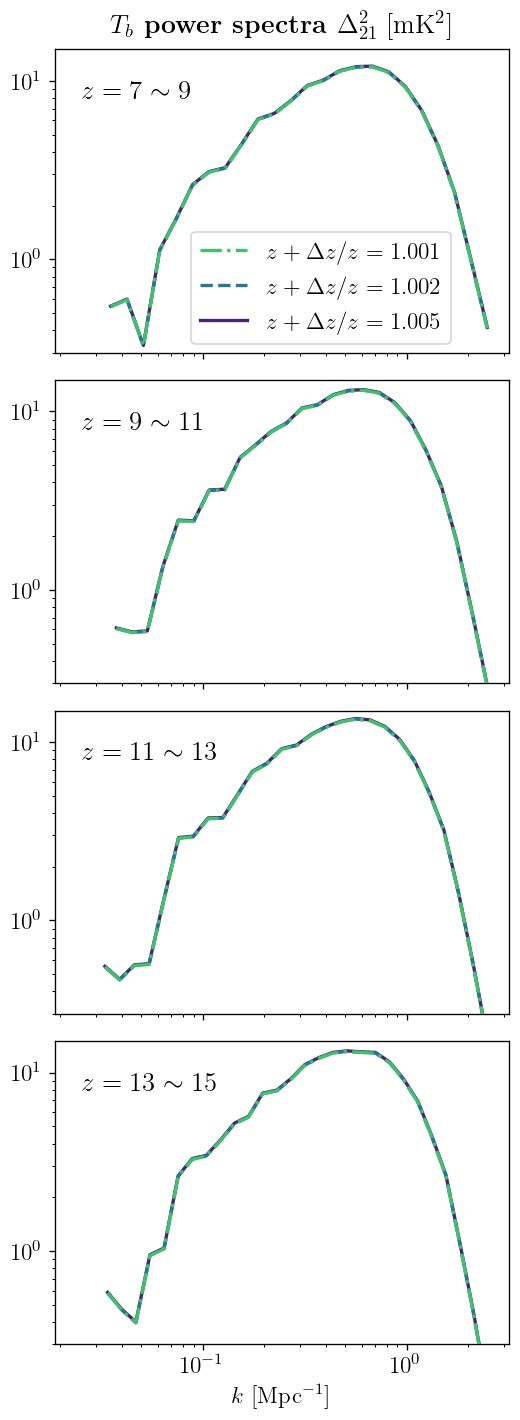

In [68]:
fig, axs = plt.subplots(4, 1, figsize=(4.5, 12), sharex=True)

x_s = [0.3, 0.6, 0.9]
color_s = [cms['viridis_r'](x) for x in x_s]
ls_s = ['-.', '--', '-']

for i_plot in range(4):
    ax = axs[i_plot]
    for i in range(3):
        ps = ps_s_s[i_plot][i]
        ax.plot(ps['k'], ps['delta'], color=color_s[i], label=zf_labels[i], zorder=10-i, lw=2, alpha=1., ls=ls_s[i])
    ax.text(0.06, 0.9, f'$z={7+i_plot*2}\\sim{9+i_plot*2}$', transform=ax.transAxes, ha='left', va='top', fontsize=16)
    ax.set(xscale='log', yscale='log', ylim=(0.3, 15))
    #ax.set(ylabel=r'$\Delta_{21}^2$ [mK$^2$]')

axs[0].legend(fontsize=14, loc=(0.3, 0.03))
axs[-1].set(xlabel=r'$k$ [Mpc$^{-1}$]')
axs[0].set_title(r'\textbf{$T_b$ power spectra $\Delta^2_{21}$} [mK$^2$]', fontsize=16, pad=10)

fig.tight_layout()
fig.savefig('convergence-ps.pdf')

In [11]:
vmin = np.max(box_s['T_b'])
vmax = np.max(box_s['T_b'])

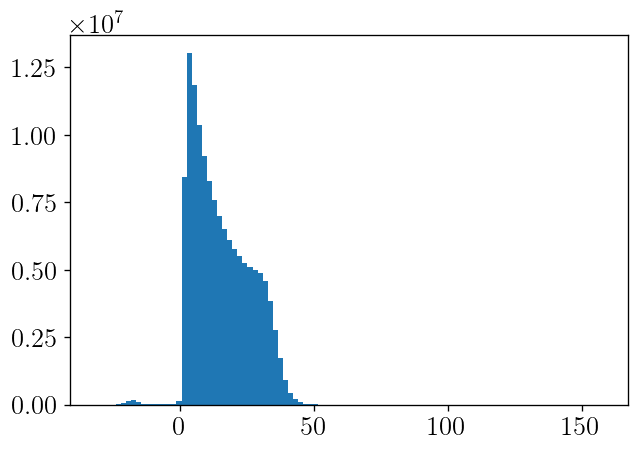

In [10]:
plt.hist(np.array(box_s['T_b']).flatten(), bins=100);

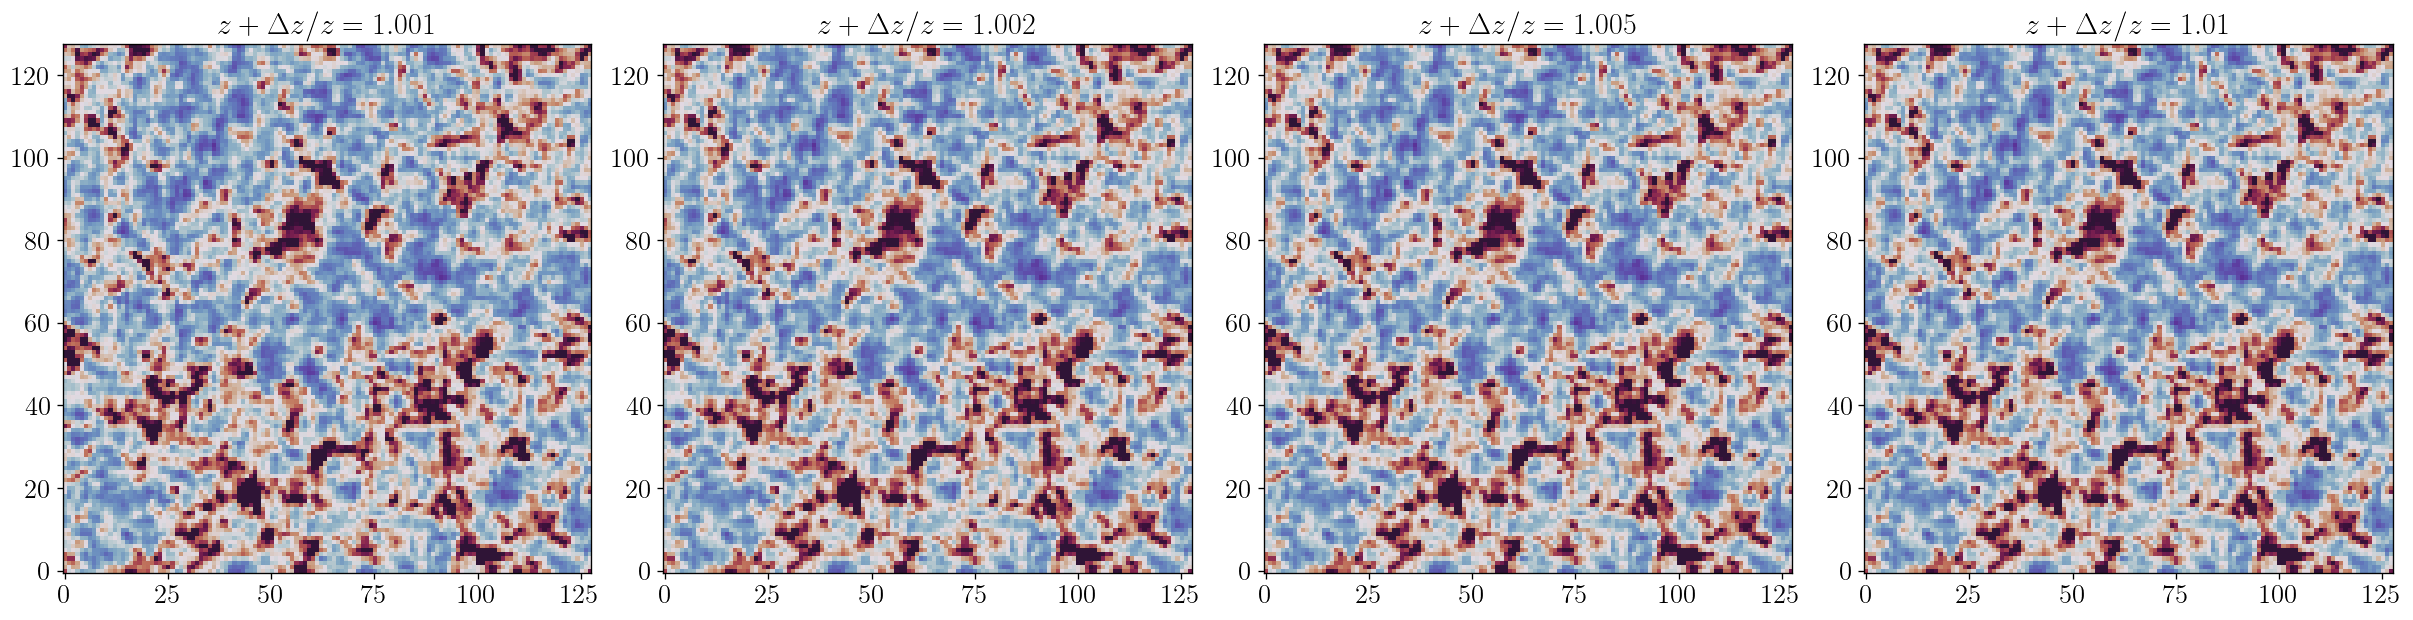

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5), layout='constrained')
for i in range(4):
    ax = axs[i]
    z = box_s['T_b'][i][:, :, 1000]
    ax.imshow(z/np.mean(z), origin='lower', cmap=cmap_dict['T_b'], vmin=0, vmax=2)
    ax.set_title(zf_labels[i])

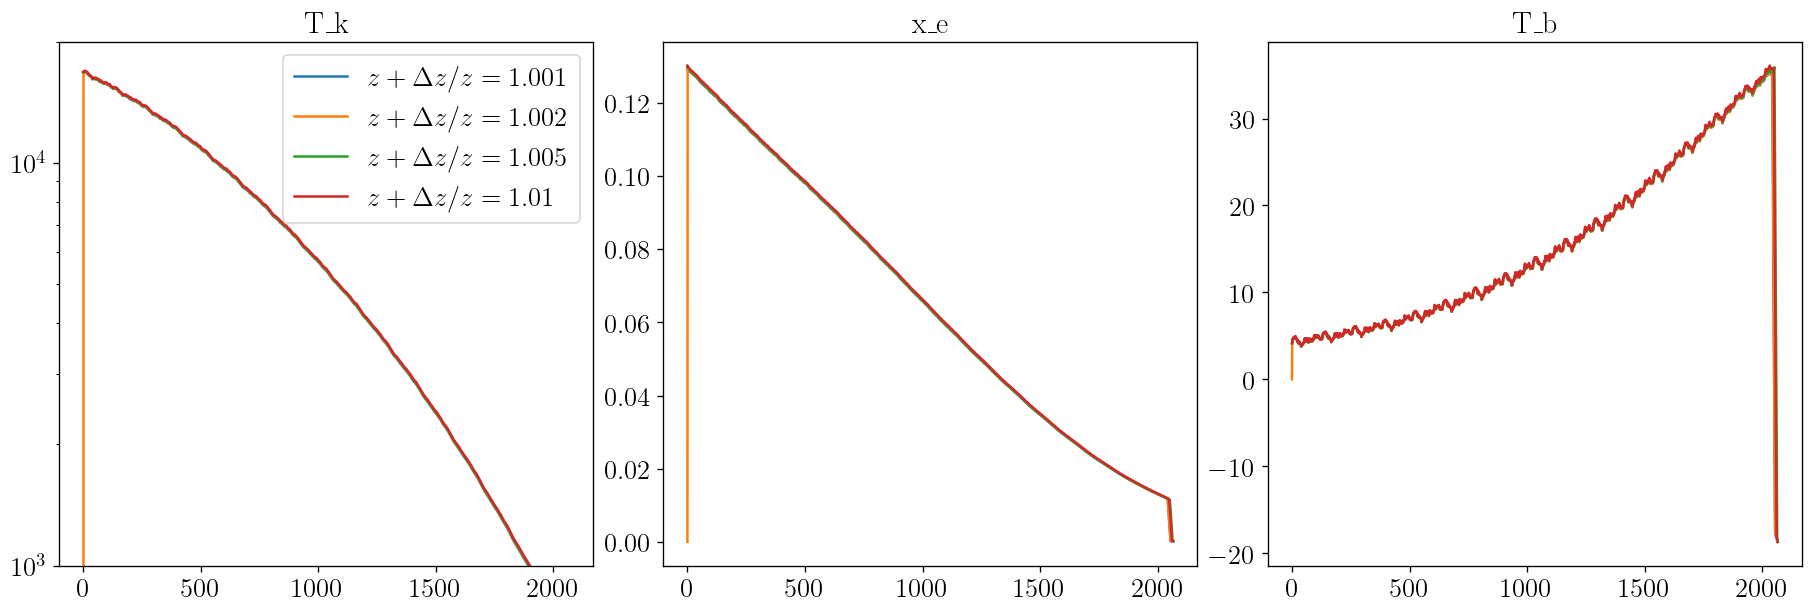

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), layout='constrained')

for i in range(4):
    ax = axs[0]
    ax.plot(np.mean(box_s['T_k'][i], axis=(0,1)), label=zf_labels[i])
    ax.set(title='T_k')
    ax = axs[1]
    ax.plot(np.mean(box_s['x_e'][i], axis=(0,1)))
    ax.set(title='x_e')
    ax = axs[2]
    ax.plot(np.mean(box_s['T_b'][i], axis=(0,1)))
    ax.set(title='T_b')
axs[0].set(yscale='log')
axs[0].set(ylim=(1e3, 2e4))
axs[0].legend()
#axs[1].set(yscale='log')
#axs[1].set(ylim=(1e3, 2e4))

[Text(0.5, 0, '$k$ [Mpc$^{-1}$]'),
 Text(0.5, 1.0, '$\\Delta_{21}^2(k)$ difference to zf001 [mK$^2$]')]

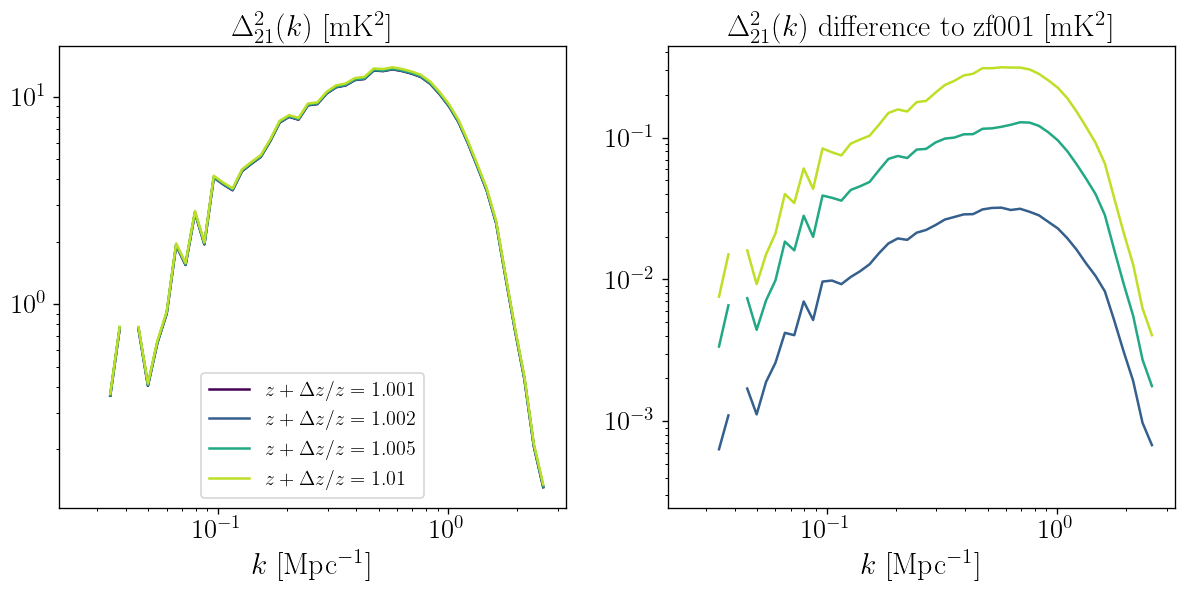

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

x_s = [0., 0.3, 0.6, 0.9]
color_s = [cms['viridis'](x) for x in x_s]

delta_base = ps_s[0][10]['delta']

for i in range(4):
    ps = ps_s[i]
    ax = axs[0]
    ax.plot(ps[10]['k'], ps[10]['delta'], color=color_s[i], label=zf_labels[i])
    ax = axs[1]
    ax.plot(ps[10]['k'], ps[10]['delta']-delta_base, color=color_s[i], label=zf_labels[i])

axs[0].set(xscale='log', yscale='log')
axs[1].set(xscale='log', yscale='log')
axs[0].legend(fontsize=12)

axs[0].set(xlabel=r'$k$ [Mpc$^{-1}$]', title=r'$\Delta_{21}^2(k)$ [mK$^2$]')
axs[1].set(xlabel=r'$k$ [Mpc$^{-1}$]', title=r'$\Delta_{21}^2(k)$ difference to zf001 [mK$^2$]');

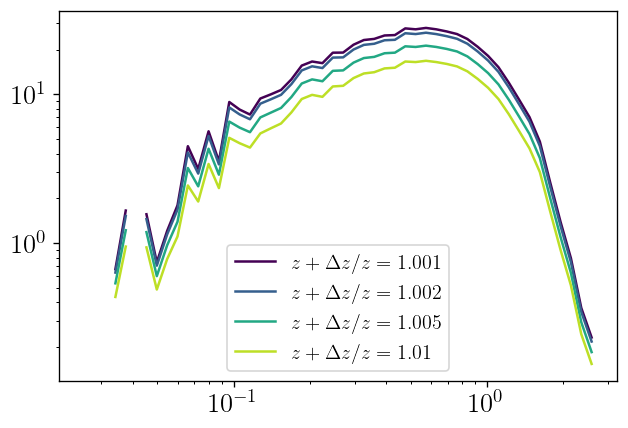

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

x_s = [0., 0.3, 0.6, 0.9]
color_s = [cms['viridis'](x) for x in x_s]

for i in range(4):
    ps = ps_s[i]
    ax.plot(ps[10]['k'], ps[10]['delta'], color=color_s[i], label=zf_labels[i])

ax.set(xscale='log', yscale='log')
ax.legend(fontsize=12)